## IMPORT LIBRARY

In [65]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns
from collections import Counter

Library dan modul yang digunakan dalam kode tersebut mencakup berbagai alat untuk pemrosesan citra, analisis statistik, serta pembelajaran mesin. os digunakan untuk operasi file dan direktori, sedangkan cv2 (OpenCV) berfungsi untuk membaca dan memproses gambar. matplotlib.pyplot dan seaborn digunakan untuk visualisasi data dan hasil analisis. numpy dan pandas merupakan pustaka utama untuk manipulasi array dan pengolahan data dalam bentuk tabel. sklearn menyediakan berbagai fungsi untuk pembelajaran mesin seperti pemisahan data (train-test split), validasi silang, klasifikasi (dengan algoritma Random Forest, SVM, dan KNN), serta metrik evaluasi model seperti akurasi, presisi, recall, F1-score, dan confusion matrix. Modul skimage.feature digunakan untuk ekstraksi fitur tekstur gambar menggunakan Gray Level Co-occurrence Matrix (GLCM), dan scipy.stats menyumbang fungsi untuk analisis statistik lanjutan seperti penghitungan entropi. Bersama-sama, library ini membentuk kerangka kerja lengkap untuk pipeline klasifikasi gambar berbasis fitur tekstur.

## Data Loading

In [66]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset/"):
    sub_folder_files = os.listdir(os.path.join("dataset/", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset/", sub_folder, filename)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)

Kode tersebut berfungsi untuk memuat dataset gambar dari folder bernama "dataset/" yang tersusun dalam subfolder sesuai dengan label kelasnya. Setiap subfolder merepresentasikan satu kelas, dan setiap file gambar di dalamnya dibaca dalam format grayscale menggunakan OpenCV (cv.imread). Gambar-gambar tersebut kemudian disimpan dalam list data, label kelas (nama subfolder) disimpan dalam list labels, dan nama file gambar disimpan dalam list file_name. Nama file diproses menggunakan os.path.splitext untuk menghilangkan ekstensi jika diperlukan. Setelah seluruh gambar diproses, list data dan labels dikonversi menjadi array NumPy agar dapat digunakan dalam proses pembelajaran mesin. Kode ini merupakan tahap awal dalam pipeline klasifikasi citra, yaitu tahap pemuatan dan pelabelan data.

## Data Understanding

Kode ini digunakan untuk melakukan data understanding dengan cara menganalisis distribusi jumlah gambar pada setiap label dalam dataset. Pertama, kode menghitung jumlah kemunculan masing-masing label menggunakan np.unique dengan opsi return_counts=True, lalu mengurutkan label dan jumlahnya agar lebih rapi saat divisualisasikan. Visualisasi dilakukan menggunakan grafik batang (bar chart) untuk menampilkan jumlah gambar per label, lengkap dengan rotasi label agar mudah dibaca. Setelah itu, informasi jumlah total data, jumlah label unik, dan distribusi data per label dicetak ke terminal untuk memberikan gambaran umum tentang keseimbangan kelas dalam dataset citra apel yang digunakan.

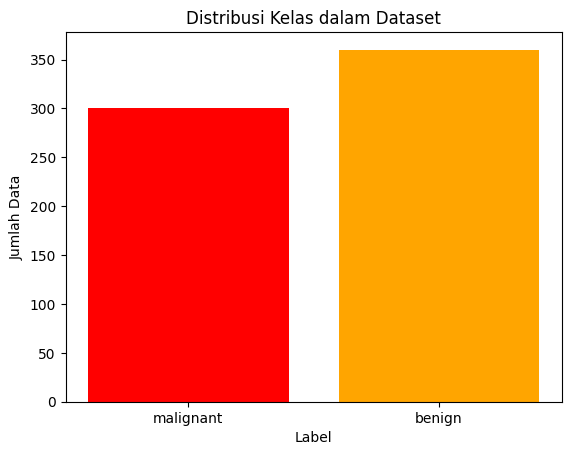

In [67]:
class_count = Counter(labels)

label_names = list(class_count.keys())
jumlah = list(class_count.values())

plt.bar(label_names, jumlah, color=['red', 'orange'])
plt.title("Distribusi Kelas dalam Dataset")
plt.xlabel("Label")
plt.ylabel("Jumlah Data")
plt.show()

## Data Preparation

### Define Preprocessing Function


In [68]:
def resize(img, baris_baru, kolom_baru):
    baris_asli, kolom_asli = img.shape

    result = np.zeros((baris_baru, kolom_baru), dtype=np.uint8)

    for i in range(baris_baru):
        for j in range(kolom_baru):
            x = int(i * baris_asli / baris_baru)
            y = int(j * kolom_asli / kolom_baru)

            x = min(x, baris_asli - 1)
            y = min(y, kolom_asli - 1)

            result[i, j] = img[x, y]

    return result

# Median Filtering
def median_filter(img, size=(3, 3)):
    result = np.zeros(img.shape, img.dtype)

    half_kern_size = (size[0]//2 ,size[1]//2)
    padded = np.pad(img, pad_width=half_kern_size, mode="edge")
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            temp = np.sort(padded[y:y+size[0], x:x+size[1]].flatten())[(size[0] * size[1]) // 2]
            result[y,x] = temp

    return result

# Deteksi Tepi Roberts Operator
def roberts_operator(img):
    kernel = np.array([[
                    [1, 0],
                    [0, -1]],
                    
                    [[0, 1],
                     [-1, 0]]])

    result = np.zeros(img.shape, dtype = img.dtype)

    padded = np.zeros((img.shape[0] + 1, img.shape[1] + 1), dtype=img.dtype)
    padded[1:, 1:] = img[:, :]

    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            sx = np.sum(padded[y:y+kernel[0].shape[0], x:x+kernel[0].shape[1]] * kernel[0])
            sy = np.sum(padded[y:y+kernel[0].shape[1], x:x+kernel[0].shape[1]] * kernel[1])

            result[y, x] = np.sqrt(sx**2 + sy**2)

    return result

# Deteksi Sobel Operator
def sobel_operator(img):
    kernel = np.array([
        [
            [-1, 0, 1],
            [-2, 0, 2],
            [-1, 0, 1]
        ],
        [
            [1, 2, 1],
            [0, 0, 0],
            [-1, -2, -1]
        ]
    ])

    result = np.zeros(img.shape, dtype=img.dtype)

    padded = np.zeros((img.shape[0] + 2, img.shape[1] + 2), dtype=img.dtype)
    padded[2:, 2:] = img[:, :]

    for y in range(result.shape[0]):
        for x in range(result.shape[1]):
            sx = np.sum(padded[y:y+kernel[0].shape[0], x:x+kernel[0].shape[1]] * kernel[0])
            sy = np.sum(padded[y:y+kernel[0].shape[1], x:x+kernel[0].shape[1]] * kernel[1])

            result[y, x] = np.sqrt(sx**2 + sy**2)

    return result

def treshold(img, value = 100):
    result = np.zeros(img.shape, img.dtype)
    result[img > value] = 255
    
    return result

Fungsi resize digunakan untuk mengubah ukuran gambar img menjadi dimensi baru yang ditentukan oleh baris_baru dan kolom_baru. Fungsi ini bekerja dengan membuat array kosong result berukuran sesuai dimensi baru, lalu mengisi setiap pikselnya dengan nilai piksel dari gambar asli berdasarkan perhitungan skala menggunakan indeks yang dipetakan dari dimensi asli ke dimensi baru. Indeks dipastikan tidak melebihi batas dimensi gambar asli menggunakan fungsi min. Hasil gambar yang telah diubah ukurannya dikembalikan sebagai output.

Median Filtering: Median filtering kami gunakan untuk menghilangkan noise pada gambar tanpa mengaburkan detail penting seperti tepi dan tekstur. Proses ini mengganti nilai tiap piksel dengan nilai median dari tetangganya dalam jendela tertentu (misalnya 3x3), sehingga efektif dalam mereduksi noise seperti salt-and-pepper yang umum ditemukan pada citra medis. Dengan mengurangi noise, hasil ekstraksi fitur menjadi lebih akurat dan stabil untuk proses klasifikasi.

Edge Detection (Roberts & Sobel Operator): Deteksi tepi menggunakan operator Roberts dan Sobel digunakan untuk menonjolkan batas atau kontur objek dalam gambar, khususnya lesi kulit. Operator Roberts mendeteksi gradien diagonal, sedangkan Sobel menangkap gradien horizontal dan vertikal dengan hasil yang lebih halus. Informasi tepi ini sangat penting karena bentuk dan batas lesi merupakan ciri visual utama dalam membedakan kanker kulit jinak dan ganas.

Thresholding: Thresholding digunakan untuk mengubah citra hasil deteksi tepi menjadi citra biner, dengan membedakan area penting (lesi) dari latar belakang berdasarkan nilai intensitas tertentu. Piksel dengan nilai di atas ambang akan dianggap sebagai bagian objek, sedangkan yang di bawahnya sebagai latar. Proses ini menyederhanakan citra dan memperjelas struktur lesi, sehingga memudahkan tahap selanjutnya seperti ekstraksi fitur dan klasifikasi.

### Preprocessing

In [69]:
dataPreprocessed = []
for i in range(len(data)):
    img = median_filter(data[i])
    img = roberts_operator(img)
    img = sobel_operator(img)
    img = treshold(img)
    
    dataPreprocessed.append(img)

Kode tersebut melakukan proses pra-pemrosesan pada data gambar dalam daftar `data` dengan menerapkan beberapa langkah secara berurutan. Pertama, setiap gambar diproses menggunakan `median_filter` untuk mengurangi noise. Kemudian, gambar tersebut diproses dengan `Roberts Operator` untuk mendeteksi tepi diagonal, diikuti oleh `Sobel Operator` untuk mendeteksi tepi horizontal dan vertikal. Setelah itu, gambar yang telah diproses melalui deteksi tepi diterapkan fungsi treshold untuk membatasi nilai piksel berdasarkan ambang tertentu, sehingga menghasilkan gambar biner atau gambar dengan intensitas tertentu. Hasil dari setiap langkah ini disimpan dalam daftar `dataPreprocessed` untuk digunakan lebih lanjut.

### Gambar Sample Data

Kode tersebut menampilkan gambar yang telah diproses dalam kelompok-kelompok berukuran 100 gambar menggunakan Matplotlib, dengan setiap kelompok diberi judul berdasarkan label pertama dari kelompok tersebut. Gambar ditampilkan dalam grid 10x10, di mana setiap subplot menampilkan gambar dari `dataPreprocessed` dengan labelnya sebagai judul. Tata letak diatur menggunakan `plt.tight_layout` agar rapi, dan hasil visualisasi ditampilkan dengan `plt.show()` untuk mempermudah analisis data secara bertahap.

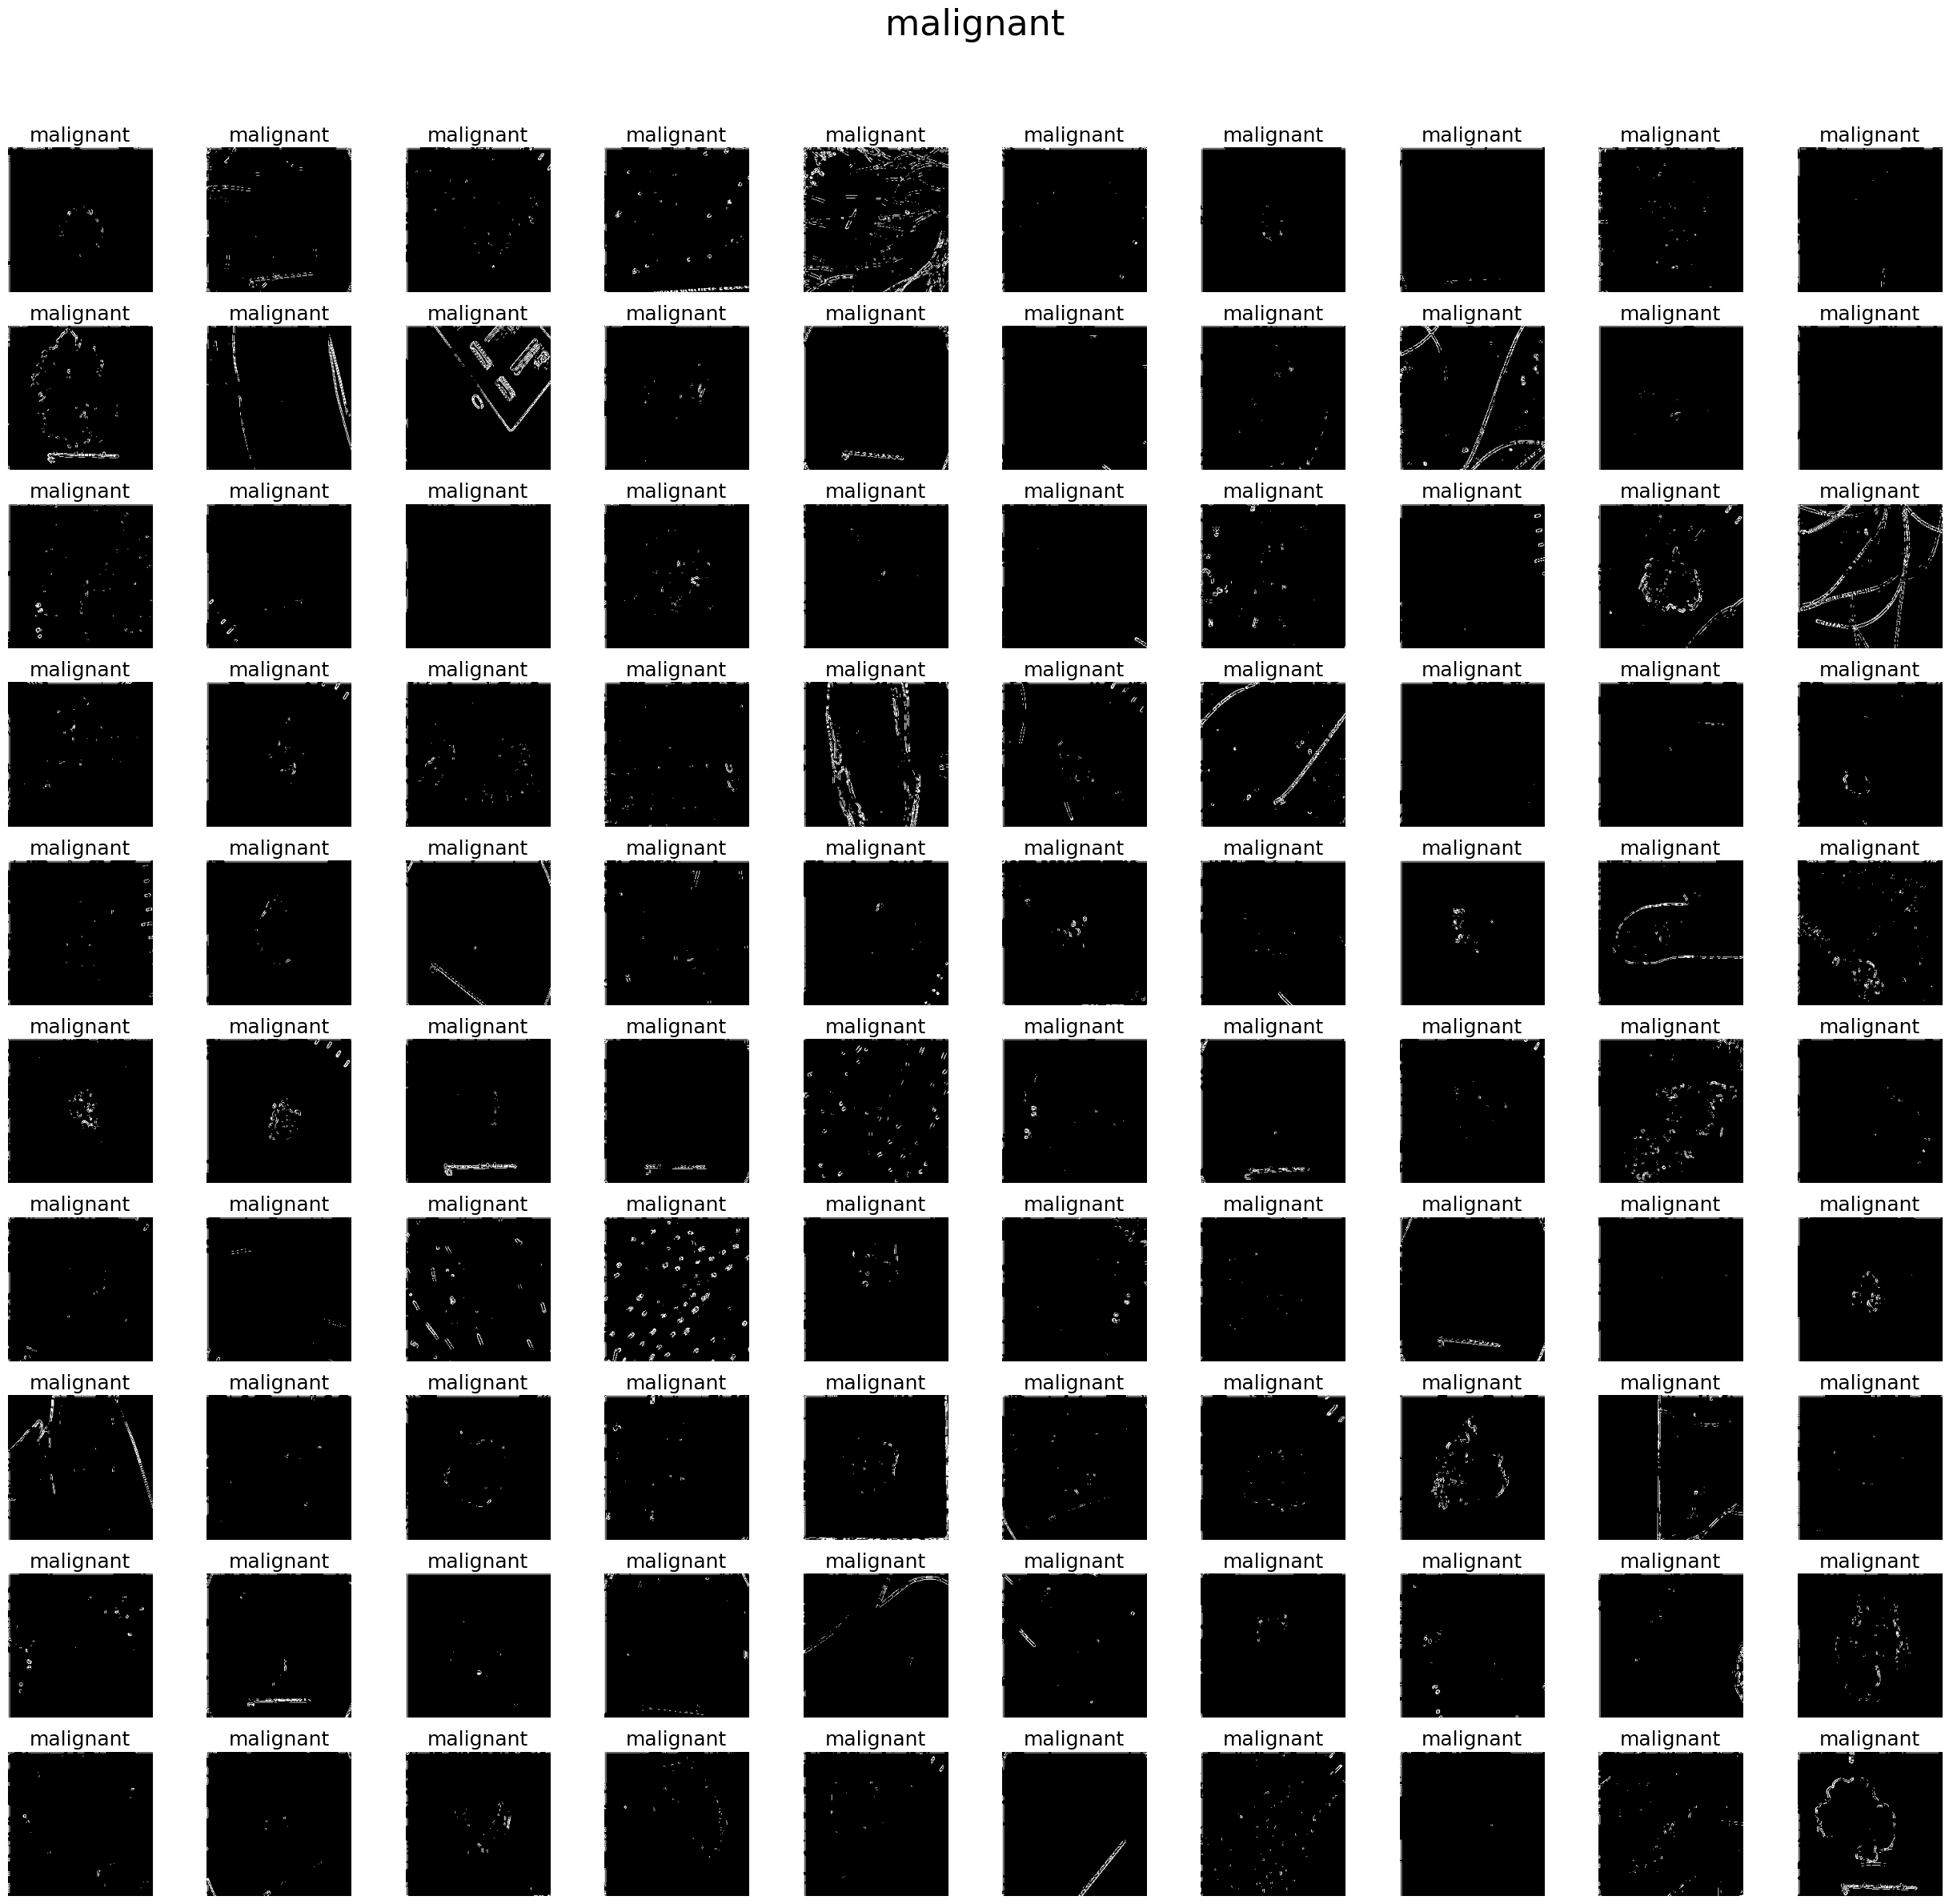

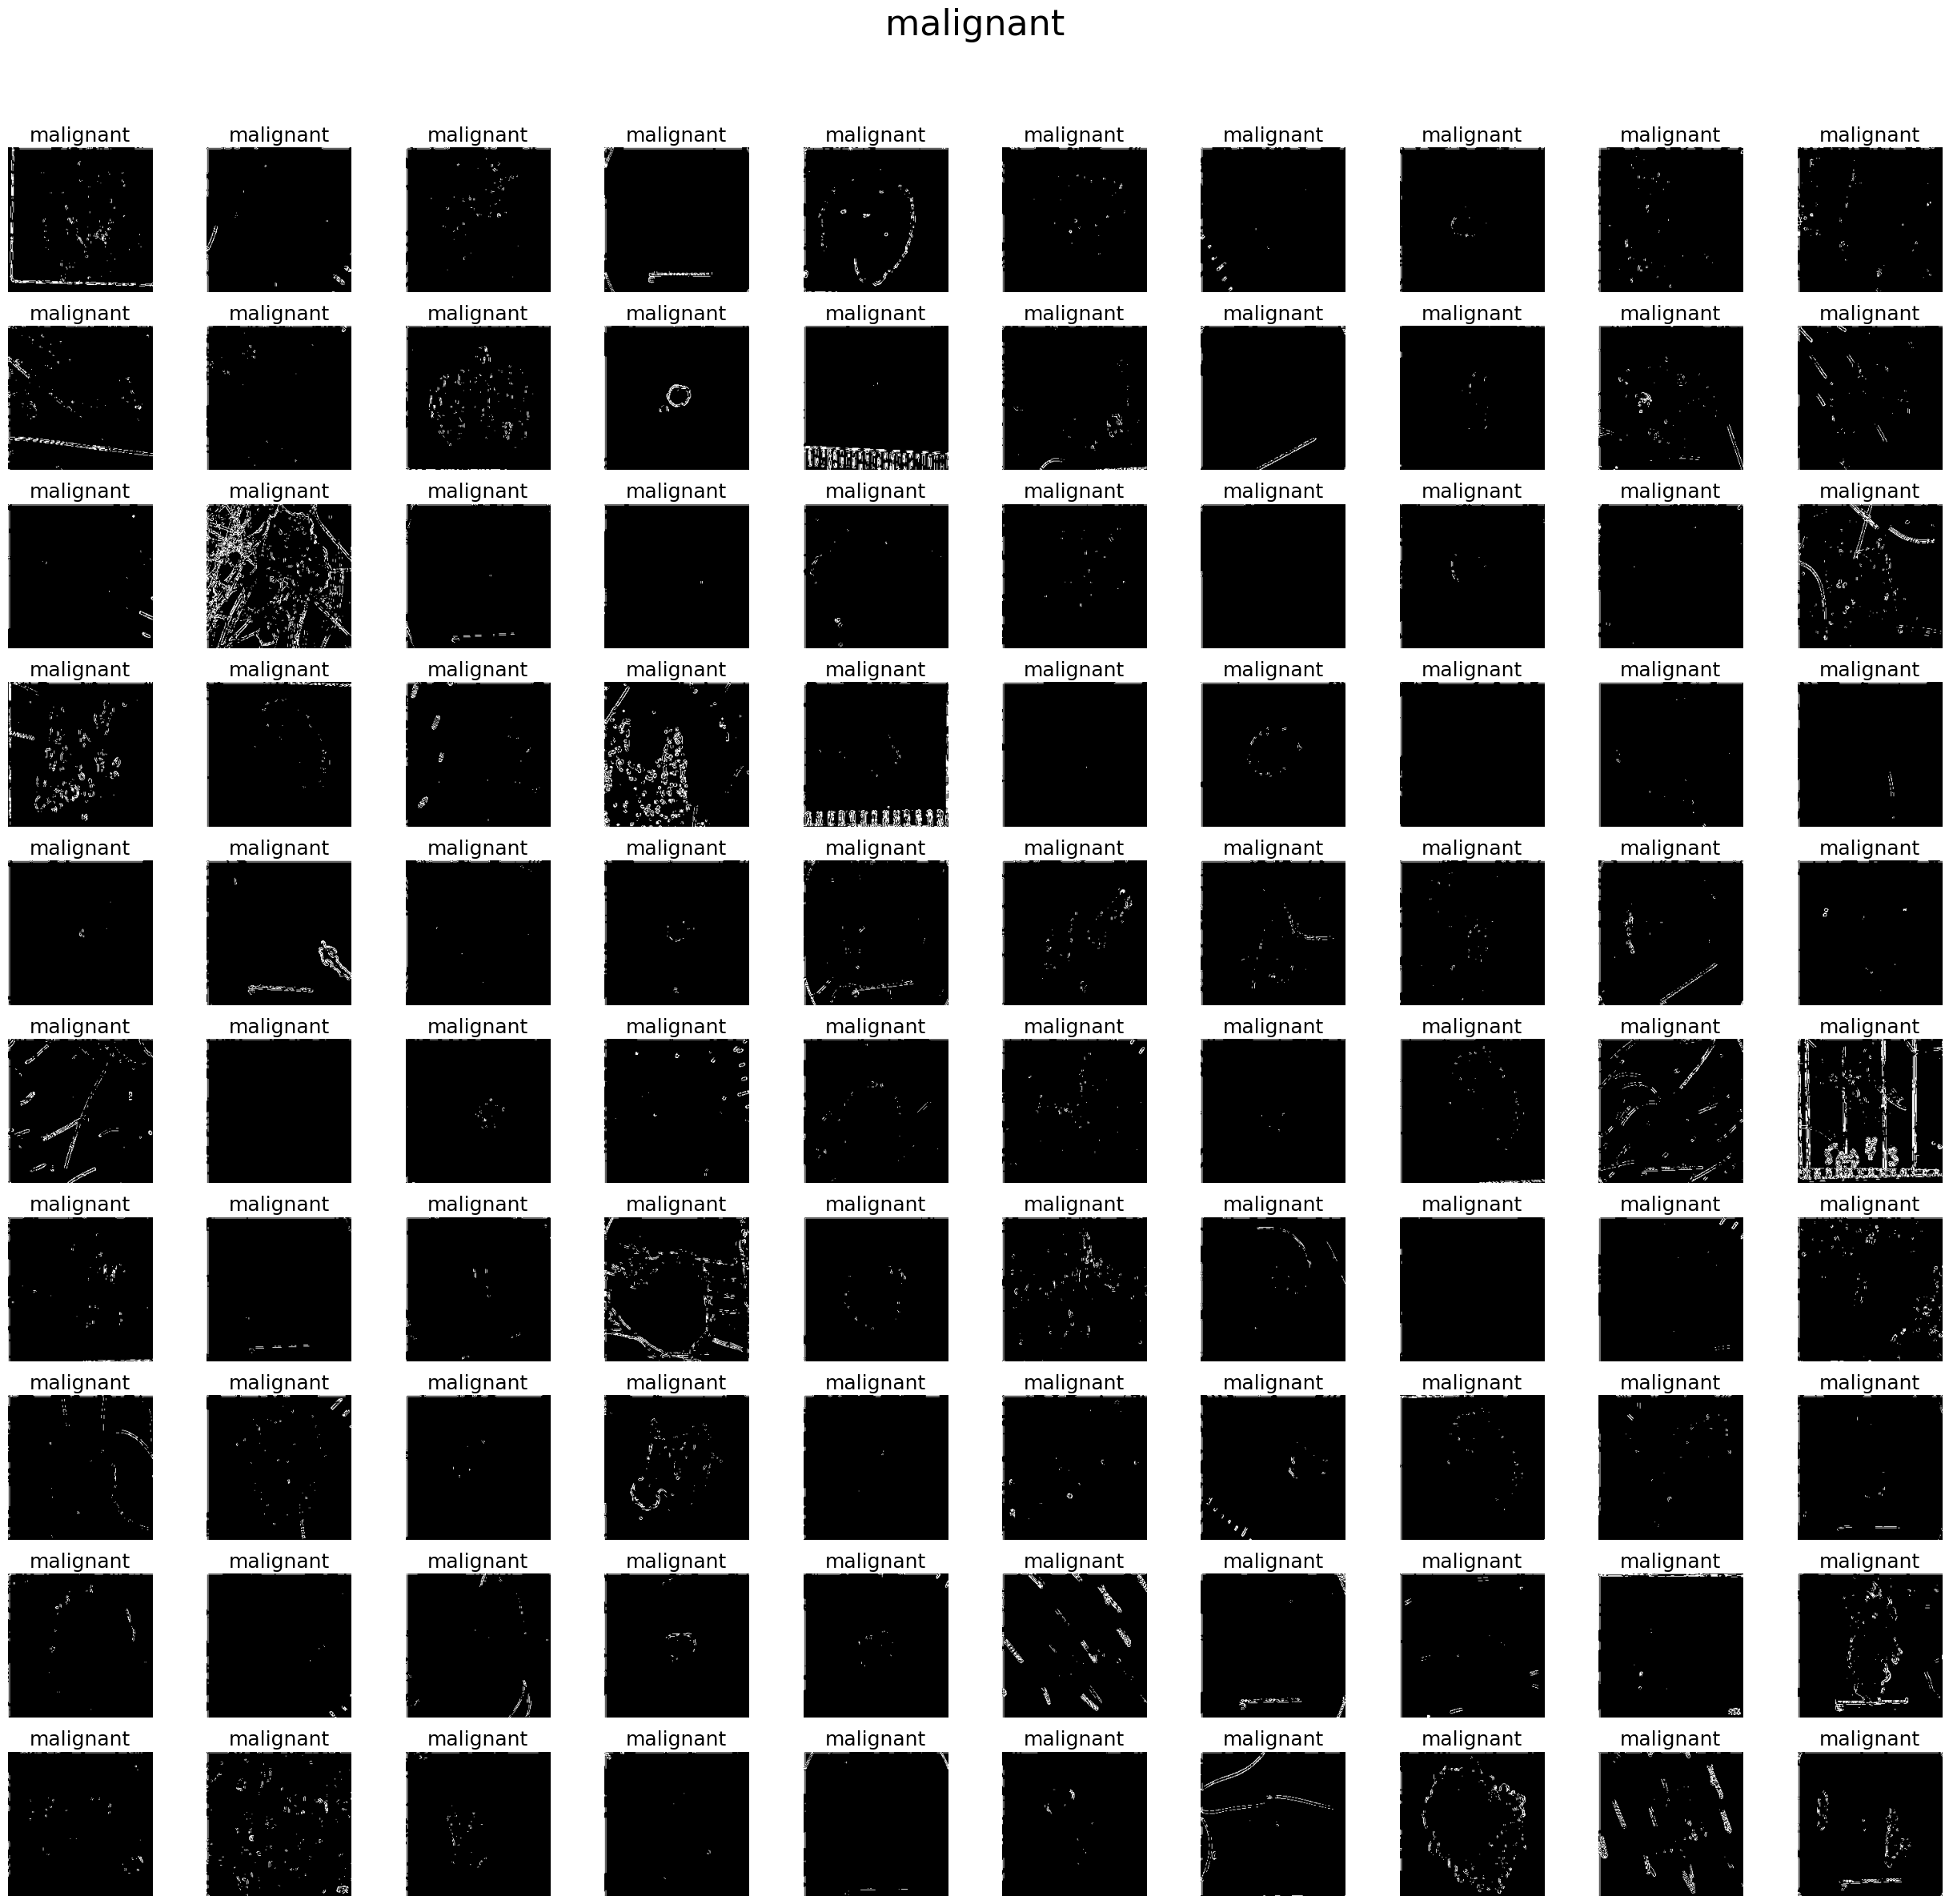

In [70]:
step = 100
img_total = 200

for i in range(img_total // step):
    plt.figure(figsize=(25, 25))
    plt.suptitle(f"{labels[i * step]}", fontsize = 32)

    for j in range(step):
        plt.subplot(10, 10, j + 1)
        plt.imshow(dataPreprocessed[(i * step) + j], cmap="gray")
        plt.title(str(labels[(i * step) + j]), fontsize = 18)
        plt.axis(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### Feature Extraction


Kode ini mendefinisikan fungsi glcm untuk menghitung Gray-Level Co-occurrence Matrix (GLCM) dari citra grayscale berdasarkan sudut tertentu (0, 45, 90, atau 135 derajat). Fungsi menerima input citra dan derajat sudut, kemudian mengonversi sudut tersebut ke radian yang diperlukan oleh fungsi graycomatrix dari library skimage.feature. GLCM dihitung dengan jarak piksel 1, diatur agar simetris dan ternormalisasi. Matriks GLCM ini sangat berguna untuk ekstraksi fitur tekstur pada citra, yang kemudian dapat digunakan dalam proses klasifikasi citra.

In [71]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric = True, normed = True)
    
    return glcm

### Fungsi Ekstraksi Fitur Korelasi dari GLCM
Kode ini mendefinisikan fungsi correlation yang digunakan untuk mengekstrak fitur korelasi dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi memanfaatkan graycoprops dari library skimage.feature dengan parameter 'correlation' untuk menghitung tingkat korelasi antar piksel dalam citra berdasarkan GLCM yang diberikan. Nilai korelasi ini menggambarkan hubungan linier antara intensitas piksel yang berdekatan dan dapat menjadi fitur penting dalam analisis tekstur citra.

In [72]:
def correlation(matriks):
	
	return graycoprops(matriks, 'correlation')[0, 0]

### Fungsi Ekstraksi Fitur Dissimilarity dari GLCM
Kode ini mendefinisikan fungsi dissimilarity untuk mengambil fitur dissimilarity dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi menggunakan graycoprops dari skimage.feature dengan parameter 'dissimilarity' untuk mengukur seberapa berbeda intensitas piksel yang berdekatan dalam citra. Nilai dissimilarity ini membantu dalam menangkap variasi tekstur dan perbedaan lokal pada citra, yang berguna untuk proses klasifikasi citra.

In [73]:
def dissimilarity(matriks):
    
    return graycoprops(matriks, 'dissimilarity')[0, 0]

### Fungsi Ekstraksi Fitur Homogeneity dari GLCM
Kode ini mendefinisikan fungsi homogenity yang digunakan untuk mengekstrak fitur homogeneity dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi memanfaatkan graycoprops dari library skimage.feature dengan parameter 'homogeneity' untuk mengukur seberapa seragam tekstur dalam citra, yaitu seberapa dekat distribusi elemen dalam GLCM ke diagonal utamanya. Nilai homogeneity yang tinggi menunjukkan tekstur yang lebih seragam, yang dapat membantu dalam membedakan karakteristik citra.

In [74]:
def homogenity(matriks):
    
    return graycoprops(matriks, 'homogeneity')[0, 0]

### Fungsi Ekstraksi Fitur Contrast dari GLCM
Kode ini mendefinisikan fungsi contrast untuk mengekstrak fitur contrast dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi menggunakan graycoprops dari skimage.feature dengan parameter 'contrast' untuk mengukur perbedaan intensitas lokal dalam citra. Nilai contrast yang tinggi menunjukkan adanya variasi tekstur yang kuat, sehingga fitur ini berguna untuk membedakan pola dan tekstur pada citra dalam proses klasifikasi.

In [75]:
def contrast(matriks):
    
    return graycoprops(matriks, 'contrast')[0, 0]

### Fungsi Ekstraksi Fitur ASM (Angular Second Moment) dari GLCM
Kode ini mendefinisikan fungsi ASM untuk mengekstrak fitur Angular Second Moment (ASM) dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi menggunakan graycoprops dari skimage.feature dengan parameter 'ASM', yang mengukur tingkat keseragaman atau energi tekstur dalam citra. Nilai ASM yang tinggi menunjukkan tekstur yang lebih homogen dan teratur, sehingga fitur ini membantu dalam analisis dan klasifikasi pola tekstur pada citra.

In [76]:
def ASM(matriks):
    
    return graycoprops(matriks, 'ASM')[0, 0]

### Fungsi Ekstraksi Fitur Energy dari GLCM
Kode ini mendefinisikan fungsi energy yang digunakan untuk mengekstrak fitur energy dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi memanfaatkan graycoprops dari library skimage.feature dengan parameter 'energy', yang merupakan akar kuadrat dari Angular Second Moment (ASM) dan mencerminkan keseragaman tekstur dalam citra. Nilai energy yang tinggi menunjukkan tekstur yang lebih konsisten dan beraturan, sehingga fitur ini penting untuk membedakan pola tekstur pada citra.

In [77]:
def energy(matriks):
    
    return graycoprops(matriks, 'energy')[0, 0]

### Fungsi Ekstraksi Fitur Entropy dari GLCM
Kode ini mendefinisikan fungsi entropyGlcm untuk menghitung fitur entropy dari matriks GLCM (Gray-Level Co-occurrence Matrix). Fungsi menggunakan entropy dari modul scipy.stats pada matriks GLCM yang telah diratakan (dirubah menjadi vektor satu dimensi) untuk mengukur tingkat ketidakteraturan atau kompleksitas tekstur citra. Nilai entropy yang tinggi menunjukkan tekstur yang lebih acak dan tidak teratur, sehingga fitur ini membantu dalam membedakan karakteristik tekstur citra.

In [78]:
def entropyGlcm(matriks):
    
    return entropy(matriks.ravel())

### Ekstraksi GLCM pada Berbagai Derajat
Kode ini melakukan ekstraksi Gray-Level Co-occurrence Matrix (GLCM) dari setiap citra dalam data preprocessing pada empat arah sudut yang berbeda: 0°, 45°, 90°, dan 135°. Dengan menggunakan fungsi glcm, setiap citra diproses untuk menghasilkan matriks GLCM pada masing-masing derajat tersebut, yang kemudian disimpan dalam list terpisah (Derajat0, Derajat45, Derajat90, Derajat135). Ekstraksi pada berbagai arah ini berguna untuk menangkap tekstur citra dari berbagai perspektif, sehingga fitur tekstur yang diperoleh lebih komprehensif dan representatif untuk klasifikasi apel segar dan busuk.

In [79]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []

for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

### Inisialisasi Variabel untuk Fitur GLCM
Kode ini membuat beberapa list kosong untuk menyimpan nilai fitur tekstur yang diekstrak dari matriks GLCM pada masing-masing sudut 0°, 45°, 90°, dan 135°. Fitur-fitur tersebut meliputi kontras (contrast), dissimilarity, homogenitas (homogeneity), entropi (entropy), angular second moment (ASM), energi (energy), dan korelasi (correlation). Setiap fitur memiliki empat list terpisah sesuai dengan arah ekstraksi GLCM, yang nantinya akan diisi dengan nilai-nilai fitur dari setiap citra dalam dataset augmentasi.

In [80]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


### Ekstraksi Fitur Korelasi dari GLCM pada Berbagai Derajat
Kode ini menghitung nilai fitur korelasi (correlation) dari matriks GLCM yang sudah diekstraksi pada empat sudut berbeda (0°, 45°, 90°, dan 135°) untuk setiap citra dalam data preprocessing. Fungsi correlation() digunakan untuk mengambil nilai korelasi dari masing-masing matriks GLCM, kemudian hasilnya disimpan ke dalam list yang sesuai (correlation0, correlation45, correlation90, correlation135). Proses ini memungkinkan pemanfaatan fitur tekstur korelasi dari berbagai arah untuk analisis dan klasifikasi citra apel segar dan busuk.

In [81]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

### Ekstraksi Fitur Kontras dari GLCM pada Berbagai Derajat
Kode ini melakukan perhitungan nilai fitur kontras (contrast) dari matriks GLCM yang telah diekstraksi pada sudut 0°, 45°, 90°, dan 135° untuk setiap citra dalam dataset preprocessing. Fungsi contrast() digunakan untuk memperoleh nilai kontras dari masing-masing matriks GLCM, kemudian nilai-nilai tersebut disimpan dalam list terpisah (Kontras0, Kontras45, Kontras90, dan Kontras135). Fitur kontras ini penting untuk menggambarkan tingkat variasi intensitas piksel pada citra, yang dapat membantu membedakan antara apel segar dan busuk berdasarkan tekstur.

In [82]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

### Ekstraksi Fitur Dissimilarity dari GLCM pada Berbagai Derajat
Kode ini mengekstrak nilai fitur dissimilarity dari matriks GLCM yang dihasilkan pada sudut 0°, 45°, 90°, dan 135° untuk setiap citra dalam dataset preprocessing. Fungsi dissimilarity() digunakan untuk menghitung tingkat perbedaan intensitas antar piksel pada citra, kemudian hasilnya disimpan dalam list terpisah (dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135). Fitur dissimilarity membantu dalam mengidentifikasi variasi tekstur yang membedakan antara apel segar dan busuk.

In [83]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

### Ekstraksi Fitur Homogeneity dari GLCM pada Berbagai Derajat
Kode ini melakukan ekstraksi fitur homogeneity dari matriks GLCM untuk sudut 0°, 45°, 90°, dan 135° pada setiap citra dalam dataset preprocessing. Fungsi homogenity() digunakan untuk mengukur keseragaman atau tingkat kemiripan intensitas piksel yang berdekatan, dan hasilnya disimpan dalam list homogenity0, homogenity45, homogenity90, dan homogenity135. Fitur homogeneity penting untuk membedakan tekstur apel segar dan busuk yang memiliki tingkat kehalusan atau kerataan yang berbeda.

In [84]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

### Ekstraksi Fitur Entropy dari GLCM pada Berbagai Derajat
Kode ini mengekstrak fitur entropy dari matriks GLCM untuk sudut 0°, 45°, 90°, dan 135° pada setiap citra dalam dataset preprocessing. Fungsi entropyGlcm() menghitung entropi, yaitu ukuran ketidakteraturan atau kompleksitas tekstur citra, dari nilai-nilai matriks GLCM yang diratakan. Nilai entropy ini kemudian disimpan dalam list entropy0, entropy45, entropy90, dan entropy135. Fitur ini membantu mengidentifikasi variasi tekstur yang membedakan apel segar dan busuk.

In [85]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

### Ekstraksi Fitur ASM (Angular Second Moment) dari GLCM pada Berbagai Derajat
Kode ini menghitung fitur Angular Second Moment (ASM) dari matriks GLCM untuk sudut 0°, 45°, 90°, dan 135° pada setiap citra dalam dataset preprocessing. ASM adalah ukuran homogenitas tekstur yang tinggi, menunjukkan seberapa seragam pola tekstur pada citra. Nilai ASM dari setiap derajat disimpan ke dalam list ASM0, ASM45, ASM90, dan ASM135. Fitur ini penting untuk membedakan tekstur apel segar dan busuk berdasarkan pola dalam citra.

In [86]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

### Ekstraksi Fitur Energy dari GLCM pada Berbagai Derajat
Kode ini menghitung fitur Energy dari matriks GLCM untuk sudut 0°, 45°, 90°, dan 135° pada setiap citra dalam dataset preprocessing. Energy merupakan akar kuadrat dari ASM dan mengukur kekompakan atau keteraturan tekstur dalam citra. Nilai energy untuk tiap derajat disimpan dalam list energy0, energy45, energy90, dan energy135. Fitur ini digunakan untuk membantu membedakan tekstur apel segar dan busuk berdasarkan pola tekstur yang muncul pada gambar.

In [87]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Penyimpanan dan Pembacaan Data Fitur Ekstraksi ke CSV
Kode ini menggabungkan seluruh fitur tekstur hasil ekstraksi GLCM dari berbagai derajat (0°, 45°, 90°, 135°) beserta label dan nama file gambar ke dalam sebuah dictionary bernama dataTable. Dictionary ini kemudian diubah menjadi DataFrame menggunakan pandas dan disimpan ke file CSV bernama 'hasil_ekstraksi_1.csv' tanpa menyertakan indeks. Selanjutnya, file CSV tersebut dibaca kembali ke dalam variabel hasilEkstrak untuk memastikan data tersimpan dengan benar dan siap untuk analisis atau pemodelan lebih lanjut. Langkah ini penting untuk mempermudah manajemen data fitur dan memungkinkan pemrosesan lanjutan dengan tools lain.

### Write the extraction's results to CSV 

In [88]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil-ekstraksi-percobaan-2-preprocessing-median-roberts-sobel-treshold.csv', index = False)

hasilEkstrak = pd.read_csv('hasil-ekstraksi-percobaan-2-preprocessing-median-roberts-sobel-treshold.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1347.jpg,malignant,1124.711723,1454.036880,679.513333,1461.882403,0.982704,0.977639,0.989550,0.977518,...,0.961441,0.953635,0.977887,0.976621,0.980531,0.976542,0.353124,0.081665,0.629664,0.078195
1,638.jpg,malignant,978.915759,1596.563876,1248.377943,1495.879668,0.984946,0.975447,0.980802,0.976996,...,0.951456,0.949690,0.977982,0.973774,0.975426,0.974520,0.475878,0.117270,0.353890,0.173518
2,1151.jpg,malignant,907.319527,1376.889240,850.042541,1349.429910,0.986047,0.978826,0.986928,0.979248,...,0.961081,0.956231,0.979850,0.977674,0.980347,0.977871,0.466097,0.096156,0.497553,0.114923
3,348.jpg,malignant,1050.511992,1757.397092,1359.026666,1677.634278,0.983845,0.972974,0.979100,0.974201,...,0.942301,0.939034,0.972291,0.968448,0.970722,0.969038,0.583152,0.245332,0.438715,0.279973
4,360.jpg,malignant,4609.495616,6860.909630,6127.335742,6364.026524,0.929113,0.894490,0.905771,0.902131,...,0.781601,0.781008,0.895400,0.880296,0.884082,0.883746,0.464574,0.192719,0.291754,0.251184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,635.jpg,benign,1012.761251,1439.653422,580.580357,1433.115486,0.984425,0.977860,0.991072,0.977961,...,0.963867,0.955431,0.979276,0.977422,0.981767,0.977462,0.393648,0.037201,0.672752,0.042391
656,147.jpg,benign,825.309297,1641.021838,864.361787,1638.406664,0.987308,0.974764,0.986707,0.974804,...,0.957578,0.950285,0.978878,0.974806,0.978559,0.974826,0.566335,-0.003310,0.546416,-0.001711
657,806.jpg,benign,930.751021,1083.989724,288.988429,1085.297311,0.985686,0.983330,0.995556,0.983310,...,0.974188,0.966128,0.983499,0.982938,0.987010,0.982918,0.231327,0.044162,0.792198,0.044092
658,1362.jpg,benign,12211.713745,13635.518510,9652.473875,9056.348408,0.812203,0.790307,0.851560,0.860727,...,0.624891,0.632336,0.773122,0.765807,0.790501,0.795195,0.248049,0.153820,0.403130,0.437925


### Features Selection

Kode tersebut menghitung matriks korelasi antar fitur dalam dataset `hasilEkstrak`, mengabaikan kolom `Label` dan `Filename`. Fitur yang memiliki korelasi absolut lebih besar atau sama dengan nilai ambang batas (`threshold = 1`) disaring untuk menghindari redundansi, dengan hanya mempertahankan satu fitur dari pasangan fitur yang sangat berkorelasi. Fitur yang terpilih disimpan dalam variabel `x_new`, sementara label disimpan dalam `y`. Selanjutnya, korelasi antar fitur yang tersisa divisualisasikan menggunakan heatmap dari Seaborn, yang memberikan gambaran hubungan antar fitur secara grafis.

<Axes: >

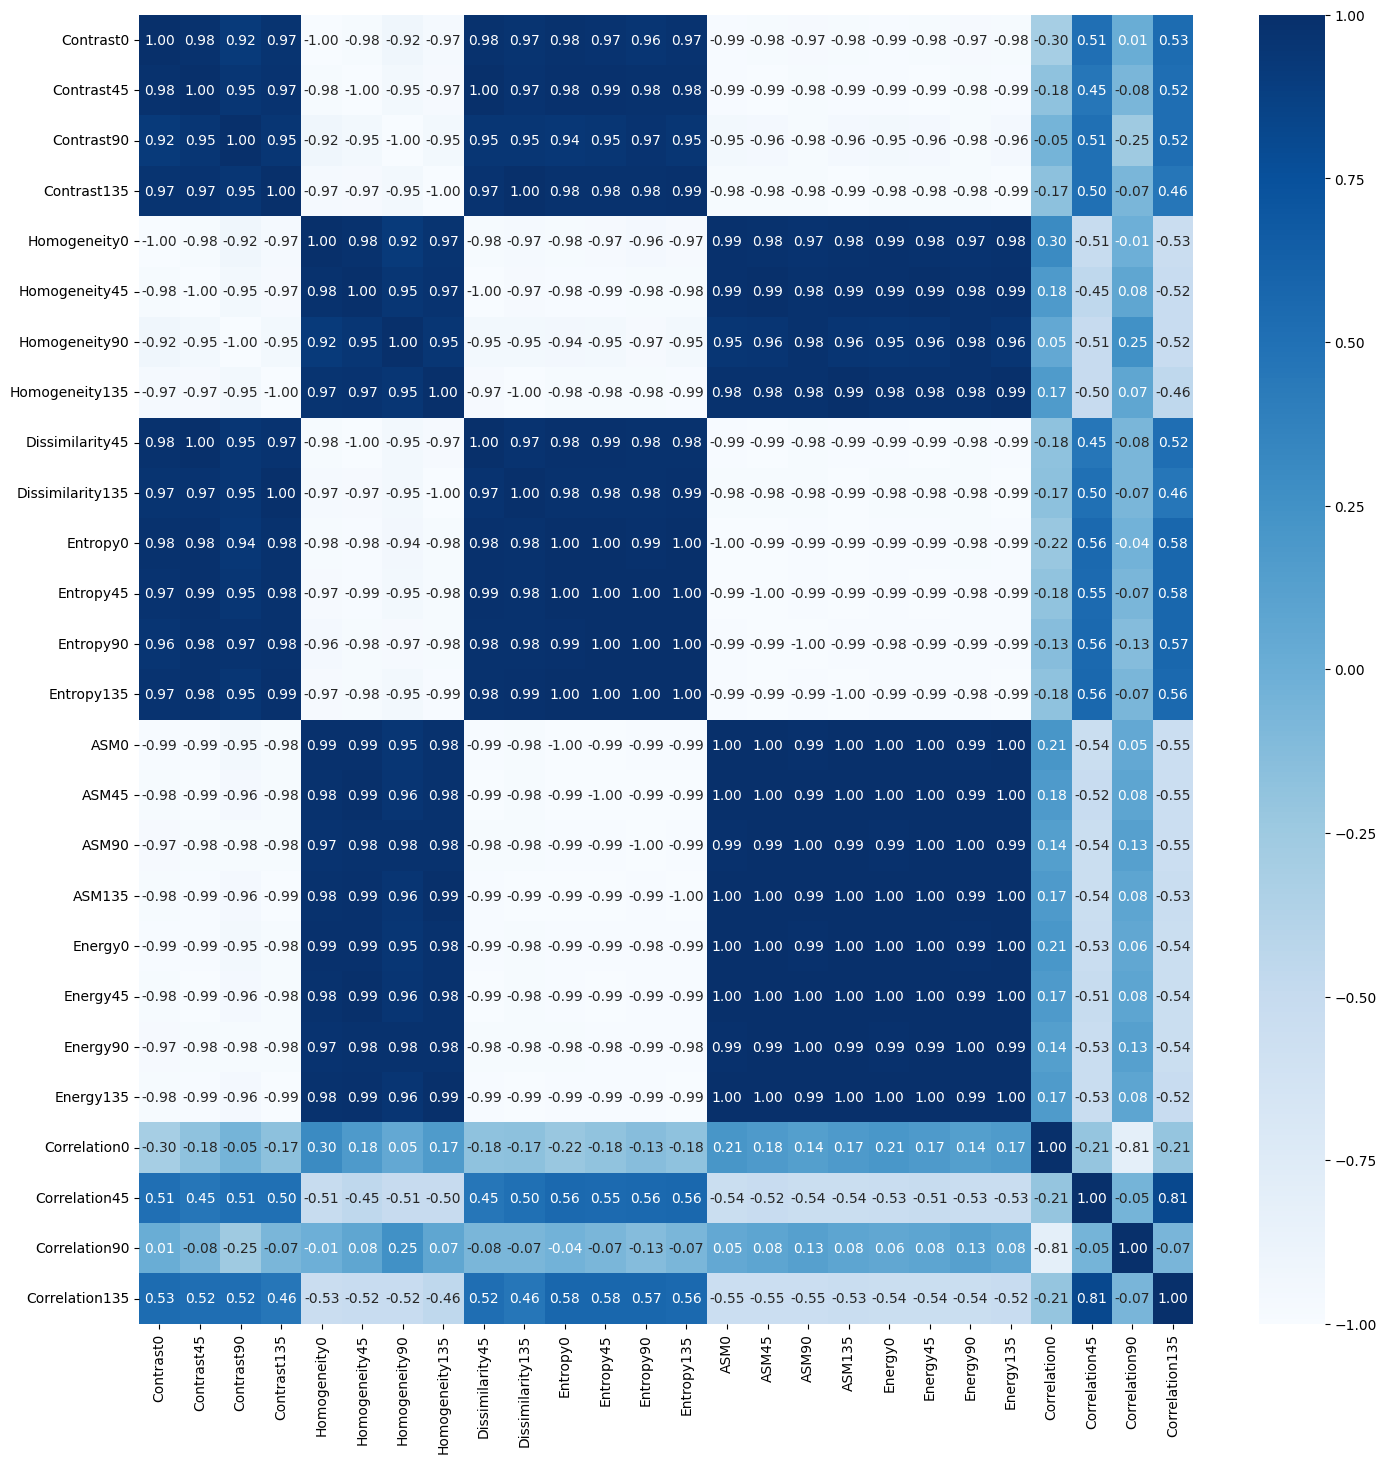

In [89]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 1 dengan label
threshold = 1
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)

for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False

select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]

x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']

plt.figure(figsize=(17, 17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### Splitting Data

Kode ini melakukan pembagian dataset fitur (x_new) dan label (y) menjadi data pelatihan (train) dan pengujian (test) menggunakan fungsi train_test_split dari scikit-learn. Parameter test_size=0.3 menunjukkan bahwa 30% data dialokasikan untuk testing, sedangkan 70% sisanya untuk training. Pengaturan random_state=42 digunakan agar pembagian data ini konsisten dan dapat direproduksi. Setelah pembagian, kode mencetak bentuk (shape) dari dataset train dan test untuk memastikan pembagian sudah sesuai.

In [90]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(528, 26)
(132, 26)


### Feature Normalization

Normalisasi Data dengan Mean dan Standar Deviasi
Kode ini melakukan normalisasi fitur pada data train dan test menggunakan metode standardisasi (z-score normalization). Data train dinormalisasi dengan mengurangi nilai rata-rata (mean) dan membagi dengan standar deviasi (std) dari data train itu sendiri agar fitur memiliki distribusi dengan rata-rata 0 dan standar deviasi 1. Data test juga dinormalisasi dengan mean dan std yang sama dari data train agar skala kedua dataset konsisten, menghindari data test 'melihat' informasi dari data test saat pelatihan.

In [91]:
# normalisasi mean dengan standardization (Z-score)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

Kode ini mendefinisikan fungsi generateClassificationReport untuk mencetak laporan evaluasi model klasifikasi yang mencakup classification report (precision, recall, f1-score), confusion matrix, dan akurasi. Selain itu, tiga algoritma klasifikasi didefinisikan: Random Forest dengan 5 pohon keputusan, Support Vector Machine (SVM) dengan kernel RBF, dan K-Nearest Neighbors (KNN) dengan 5 tetangga. Ketiga model ini akan digunakan untuk melakukan pelatihan dan evaluasi pada dataset.

In [92]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

Kode ini melatih model Random Forest menggunakan data latih (X_train, y_train). Setelah pelatihan selesai, model digunakan untuk melakukan prediksi pada data latih dan data uji (X_test). Hasil prediksi tersebut kemudian dievaluasi dengan fungsi generateClassificationReport yang menampilkan classification report, confusion matrix, dan akurasi untuk kedua set data. Tujuan dari langkah ini adalah untuk mengetahui seberapa baik model dapat mengklasifikasikan data yang sudah dilatih maupun data yang belum pernah dilihat sebelumnya (testing).

In [93]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

      benign       0.97      0.98      0.97       294
   malignant       0.97      0.96      0.96       234

    accuracy                           0.97       528
   macro avg       0.97      0.97      0.97       528
weighted avg       0.97      0.97      0.97       528

[[287   7]
 [ 10 224]]
Accuracy: 0.9678030303030303

------Testing Set------
              precision    recall  f1-score   support

      benign       0.58      0.65      0.61        66
   malignant       0.60      0.53      0.56        66

    accuracy                           0.59       132
   macro avg       0.59      0.59      0.59       132
weighted avg       0.59      0.59      0.59       132

[[43 23]
 [31 35]]
Accuracy: 0.5909090909090909


### Train SVM Classifier


Kode ini melatih model Support Vector Machine (SVM) dengan kernel RBF menggunakan data latih (X_train, y_train). Setelah model dilatih, prediksi dilakukan pada data latih dan data uji (X_test). Fungsi generateClassificationReport digunakan untuk menampilkan metrik evaluasi seperti classification report, confusion matrix, dan akurasi pada kedua set data. Langkah ini bertujuan mengukur performa model SVM dalam mengklasifikasikan citra dengan fitur GLCM yang telah diekstraksi.

In [94]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

      benign       0.74      0.81      0.77       294
   malignant       0.72      0.64      0.68       234

    accuracy                           0.73       528
   macro avg       0.73      0.72      0.72       528
weighted avg       0.73      0.73      0.73       528

[[237  57]
 [ 85 149]]
Accuracy: 0.7310606060606061

------Testing Set------
              precision    recall  f1-score   support

      benign       0.68      0.82      0.74        66
   malignant       0.77      0.61      0.68        66

    accuracy                           0.71       132
   macro avg       0.72      0.71      0.71       132
weighted avg       0.72      0.71      0.71       132

[[54 12]
 [26 40]]
Accuracy: 0.7121212121212122


### Train KNN Classifier

Kode ini melatih model K-Nearest Neighbors (KNN) dengan k=5 menggunakan data latih (X_train, y_train). Setelah pelatihan selesai, model melakukan prediksi pada data latih dan data uji (X_test). Fungsi generateClassificationReport kemudian digunakan untuk menampilkan hasil evaluasi berupa classification report, confusion matrix, dan akurasi untuk kedua set data tersebut. Proses ini bertujuan untuk menilai kemampuan model KNN dalam mengklasifikasikan fitur GLCM dari dataset apel busuk dan segar.

In [95]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

      benign       0.80      0.84      0.82       294
   malignant       0.78      0.74      0.76       234

    accuracy                           0.79       528
   macro avg       0.79      0.79      0.79       528
weighted avg       0.79      0.79      0.79       528

[[246  48]
 [ 62 172]]
Accuracy: 0.7916666666666666

------Testing Set------
              precision    recall  f1-score   support

      benign       0.65      0.68      0.67        66
   malignant       0.67      0.64      0.65        66

    accuracy                           0.66       132
   macro avg       0.66      0.66      0.66       132
weighted avg       0.66      0.66      0.66       132

[[45 21]
 [24 42]]
Accuracy: 0.6590909090909091


## Evaluation With Confusion Matrix

Evaluasi dan Perbandingan Beberapa Model Klasifikasi
Kode ini melakukan pelatihan dan evaluasi tiga model klasifikasi: Random Forest, SVM, dan KNN, menggunakan data latih dan data uji yang sudah disiapkan. Setiap model dilatih pada X_train dan y_train, lalu dilakukan prediksi untuk data latih dan data uji. Akurasi hasil prediksi pada kedua data tersebut dihitung dan disimpan. Setelah seluruh model dievaluasi, hasil akurasi training dan testing ditampilkan untuk membandingkan performa masing-masing model. Terakhir, kode ini juga menentukan model dengan akurasi testing tertinggi dan menampilkannya sebagai model terbaik untuk klasifikasi dataset kanker kulit jinak dan ganas.

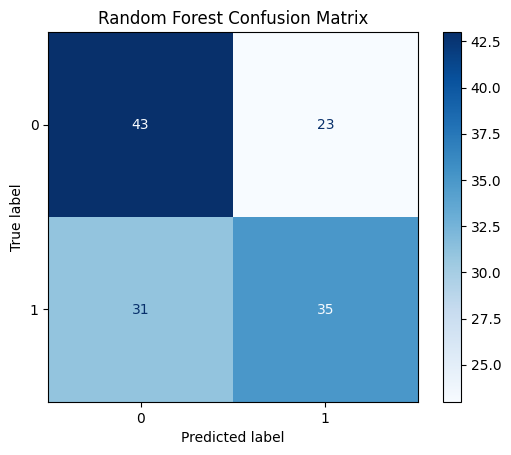

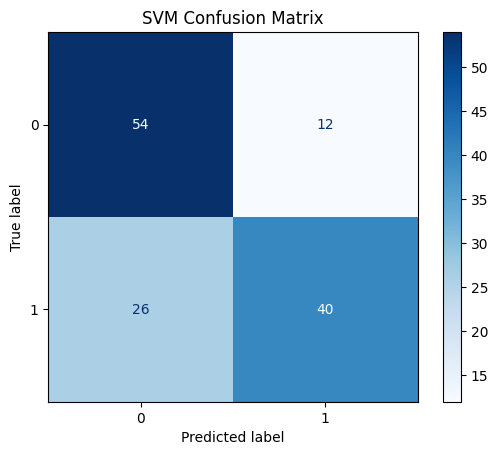

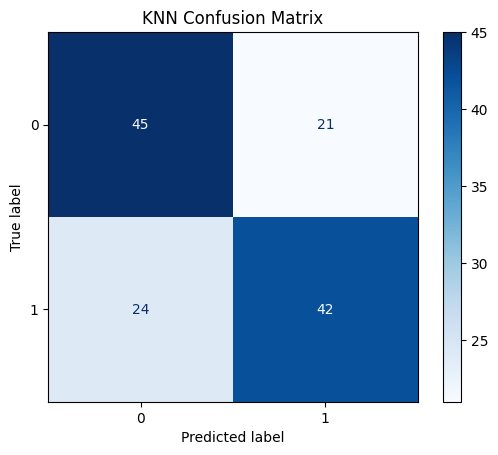

In [96]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")

# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")

# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")